In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cross_validation import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics

#import sys
#!{sys.executable} -m pip install xgboost


import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

C:\Users\Poori\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os
os.chdir("C:\\Users\\Poori\\Desktop\\Udemy\\A-Z Machine learning Kaggle\\Ensemble models\\Boosting")
housing = pd.read_csv('train_sample.csv')

In [3]:
housing.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [4]:
housing.isnull().sum()

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    99773
is_attributed          0
dtype: int64

In [5]:
housing.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

In [11]:
dtypes_1 = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        #'click_id'      : 'uint32' # note that click_id is only in test data, not training data
        }

In [31]:
train_sample = pd.read_csv('train_sample.csv', dtype=dtypes_1)
train_sample.drop('attributed_time',axis=1,inplace=True)

In [32]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
click_time       object
is_attributed     uint8
dtype: object

In [33]:
lst1=[]
for i in train_sample.columns:
    lst=len(train_sample[i].unique())
    lst1.append(lst)
    #print(len(train_sample[i].unique()))
clname=train_sample.columns
#print(clname)
#print(lst1)
np.c_[list(clname),list(lst1)]

array([['ip', '28470'],
       ['app', '161'],
       ['device', '100'],
       ['os', '130'],
       ['channel', '161'],
       ['click_time', '80350'],
       ['is_attributed', '2']], dtype='<U13')

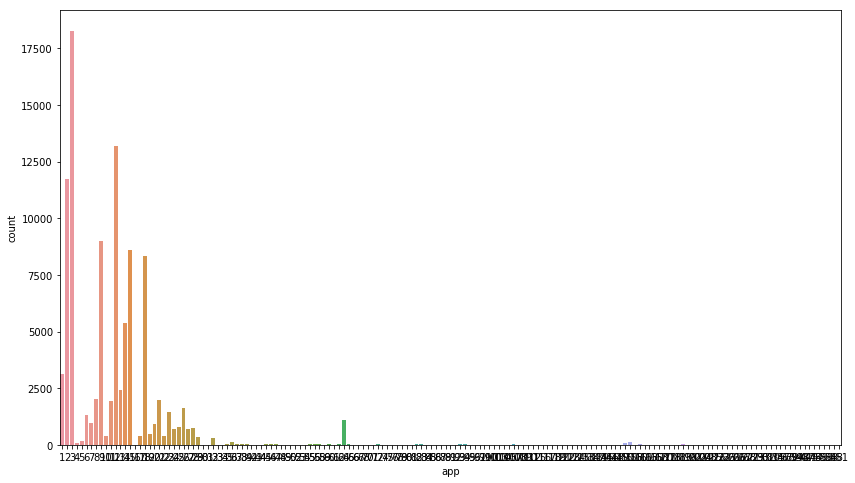

In [34]:
plt.figure(figsize=(14, 8))
sns.countplot(x="app", data=train_sample)

In [35]:
#here we have very high class imbalance
train_sample.head()
(train_sample.is_attributed.value_counts()/len(train_sample.is_attributed))*100

0    99.773
1     0.227
Name: is_attributed, dtype: float64

In [36]:
frequent_apps = train_sample.groupby('app').size().reset_index(name='count')
frequent_apps = frequent_apps[frequent_apps['count']>frequent_apps['count'].quantile(0.80)]
frequent_apps = frequent_apps.merge(train_sample, on='app', how='inner')
frequent_apps.head()
frequent_apps.app.unique() #only those apps who count is above 80 percent quantile

array([  1,   2,   3,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  32,  36,  64, 150, 151], dtype=uint64)

In [37]:
df=train_sample
df['datetime'] = pd.to_datetime(df['click_time'])
df['day_of_week'] = df['datetime'].dt.dayofweek
df["day_of_year"] = df["datetime"].dt.dayofyear
df["month"] = df["datetime"].dt.month
df["hour"] = df["datetime"].dt.hour
train_sample=df
train_sample.head()

,ip,app,device,os,channel,click_time,is_attributed,datetime,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,2017-11-07 09:30:38,0,2017-11-07 09:30:38,1,311,11,9
1,40024,25,1,17,259,2017-11-07 13:40:27,0,2017-11-07 13:40:27,1,311,11,13
2,35888,12,1,19,212,2017-11-07 18:05:24,0,2017-11-07 18:05:24,1,311,11,18
3,29048,13,1,13,477,2017-11-07 04:58:08,0,2017-11-07 04:58:08,1,311,11,4
4,2877,12,1,1,178,2017-11-09 09:00:09,0,2017-11-09 09:00:09,3,313,11,9


In [38]:
train_sample.drop(['click_time', 'datetime'], axis=1, inplace=True)
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [40]:
colnames=list(train_sample.columns)
train_sample[colnames] = train_sample[colnames].astype('uint16')

In [41]:
train_sample.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed    uint16
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [43]:
df=train_sample
ip_count = df.groupby('ip').size().reset_index(name='ip_count').astype('uint16')
ip_day_hour = df.groupby(['ip', 'day_of_week', 'hour']).size().reset_index(name='ip_day_hour').astype('uint16')
ip_hour_channel = df[['ip', 'hour', 'channel']].groupby(['ip', 'hour', 'channel']).size().reset_index(name='ip_hour_channel').astype('uint16')
ip_hour_os = df.groupby(['ip', 'hour', 'os']).channel.count().reset_index(name='ip_hour_os').astype('uint16')
ip_hour_app = df.groupby(['ip', 'hour', 'app']).channel.count().reset_index(name='ip_hour_app').astype('uint16')
ip_hour_device = df.groupby(['ip', 'hour', 'device']).channel.count().reset_index(name='ip_hour_device').astype('uint16')
    
# merge the new aggregated features with the df
df = pd.merge(df, ip_count, on='ip', how='left')
del ip_count
df = pd.merge(df, ip_day_hour, on=['ip', 'day_of_week', 'hour'], how='left')
del ip_day_hour
df = pd.merge(df, ip_hour_channel, on=['ip', 'hour', 'channel'], how='left')
del ip_hour_channel
df = pd.merge(df, ip_hour_os, on=['ip', 'hour', 'os'], how='left')
del ip_hour_os
df = pd.merge(df, ip_hour_app, on=['ip', 'hour', 'app'], how='left')
del ip_hour_app
df = pd.merge(df, ip_hour_device, on=['ip', 'hour', 'device'], how='left')
del ip_hour_device
train_sample=df

In [44]:
train_sample.head()

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour,...,ip_hour_channel_x,ip_hour_os_x,ip_hour_app_x,ip_hour_device_x,ip_count_y,ip_day_hour_y,ip_hour_channel_y,ip_hour_os_y,ip_hour_app_y,ip_hour_device_y
0,22004,12,1,13,497,0,1,311,11,9,...,1,1,1,1,8,1,1,1,1,1
1,40024,25,1,17,259,0,1,311,11,13,...,1,1,1,8,149,4,1,1,1,8
2,35888,12,1,19,212,0,1,311,11,18,...,1,1,1,1,2,1,1,1,1,1
3,29048,13,1,13,477,0,1,311,11,4,...,1,1,1,1,3,1,1,1,1,1
4,2877,12,1,1,178,0,3,313,11,9,...,1,1,1,1,4,1,1,1,1,1


In [45]:
gc.collect()

2516

In [46]:
X = train_sample.drop('is_attributed', axis=1)
y = train_sample[['is_attributed']]

# split data into train and test/validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [ ]:
# base estimator
tree = DecisionTreeClassifier(max_depth=2)
# adaboost with the tree as base estimator
adaboost_model_1 = AdaBoostClassifier(
    base_estimator=tree,
    n_estimators=600,
    learning_rate=1.5,
    algorithm="SAMME")

In [ ]:
adaboost_model_1.fit(X_train, y_train)

In [ ]:
predictions = adaboost_model_1.predict_proba(X_test)
predictions[:10]
metrics.roc_auc_score(y_test, predictions[:,1])

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)
y_pred[:10]
metrics.roc_auc_score(y_test, predictions[:,1])